# Reconstruction Demo with the Proposed approach
This notebook loads the neural networks defined in the models folder with the checkpoints provided in the weights folder. This demo is specific to the case of SparseCT reconstruction with 90-views. 

In [1]:
# Import all the necessary libraries
import tensorflow as tf
import glob
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from models.dense import *
from models.unet import *
from PIL import Image

## 1. Data Visualisation

In [2]:
# Path to the test data

GT_dir = sorted(glob.glob("data_for_test/GT/*"))      # Path to the ground truth images
sino_dir = sorted(glob.glob("data_for_test/sino/*"))  # Path to the sparse-view sinograms
bp_dir = sorted(glob.glob("data_for_test/bp/*"))      # FBP estimates from the sparse sinograms


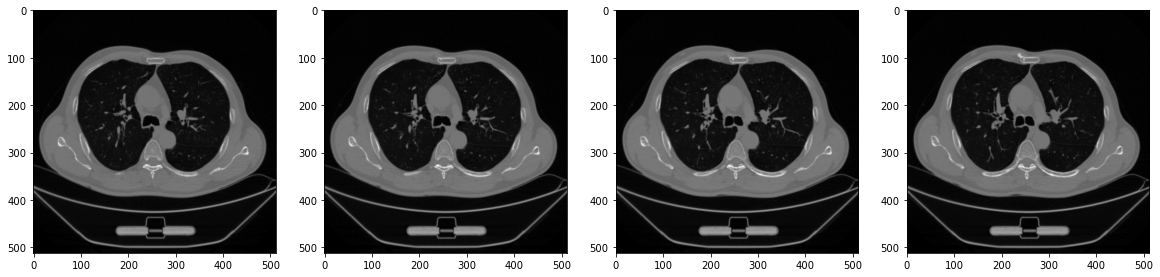

In [3]:
# Visualise GT

w = 20 # display height
h = 20 # diplay width
fig = plt.figure(figsize=(w,h))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    img = (np.asarray(Image.open(GT_dir[i])))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap="gray")
plt.show()

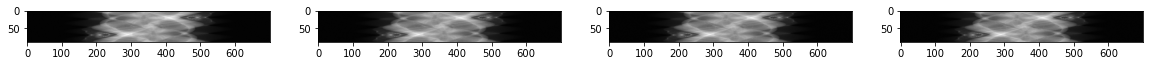

In [4]:
# Visualise Sinogram

w = 20 # display height
h = 20 # diplay width
fig = plt.figure(figsize=(w,h))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    img = (np.asarray(Image.open(sino_dir[i])))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap="gray")
plt.show()

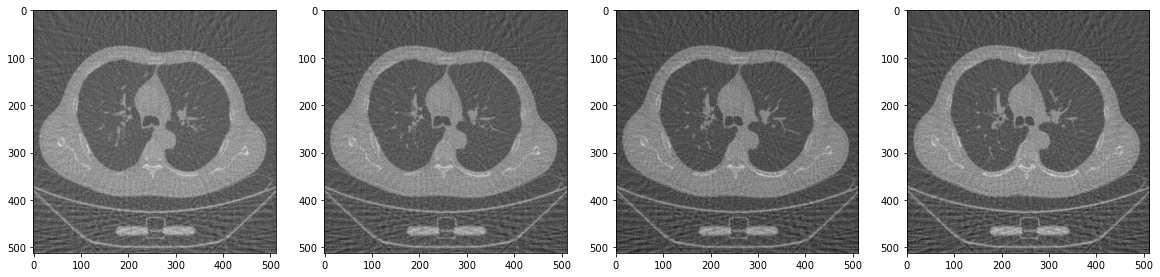

In [5]:
# Visualise FBP estimate

w = 20 # display height
h = 20 # diplay width
fig = plt.figure(figsize=(w,h))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    img = (np.asarray(Image.open(bp_dir[i])))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap="gray")
plt.show()

## 2. Data Pre-processing

In [6]:
# Variables for image dimensions 

H = 512 # height
W = 512 # width 

M1 = 64  # concatenation 1 for DenseNet
N1 = 128 # concatenation 2 for DenseNet 

M2 = 128 # concatenation 1 for U-Net 
N2 = 256 # concatenation 2 for U-Net 

In [7]:
# Function to normalise images to the range [0,1]
def normalise(X):

    return (X-np.amin(X))/(np.amax(X)-np.amin(X)+1e-4)


In [8]:
# Function that returns sinogram, concatenations of (m,m) and (n,n) and GT image
def load_img(index,m,n):
    
    y=normalise(resize(np.asarray(Image.open(GT_dir[index])),(H,W)))
    temp = resize(np.asarray(Image.open(sino_dir[index])),(H,W))
    x1=(normalise(temp))
    x2=normalise(resize(np.asarray(Image.open(bp_dir[index])),(m,m)))    
    x3=(normalise(resize(np.asarray(Image.open(bp_dir[index])),(n,n))))            

    return x1.reshape((1,H,W,1)),x2.reshape((1,m,m,1)),x3.reshape((1,n,n,1)),y.reshape((1,H,W,1))


## 3. Model Definition 

In [9]:
# DenseNet Model
dense = LRRCED_D(input_shape=(H,W,1))
dense.load_weights("weights/direct_dense_10.h5")

11


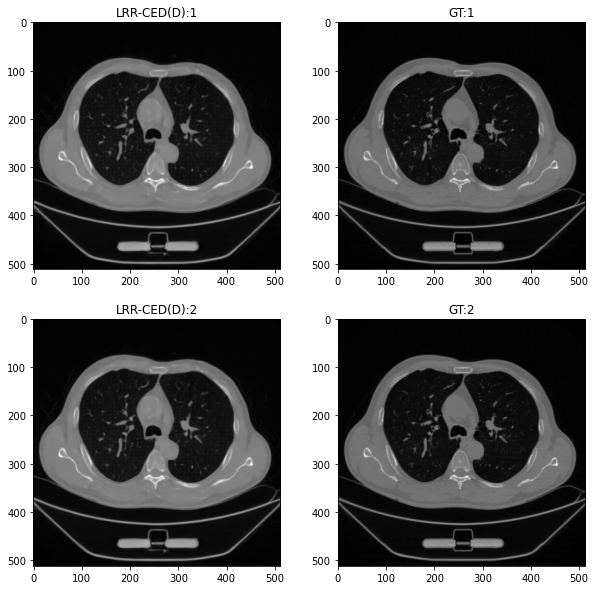

In [10]:
w = 10 # display height
h = 10 # display width

t_n = 2 # number of testing examples to display

GT   = np.zeros((t_n,H,W,1))
pred = np.zeros((t_n,H,W,1))


for i in range(0, t_n):
    
    sino, x1,x2, GT[i] = load_img(i,M1,N1)
    pred[i] = dense.predict([sino,x1,x2])

f, axarr = plt.subplots(t_n,2,figsize=(w,h))

for k in range(t_n):
       
    axarr[k,0].imshow(pred[0].reshape(H,W),cmap="gray")
    axarr[k,0].set_title("LRR-CED(D):"+str(k+1)) 
    axarr[k,1].imshow(GT[0].reshape(H,W),cmap="gray")
    axarr[k,1].set_title("GT:"+str(k+1)) 

plt.show()

In [12]:
# Unet Model
unet_1 = LRRCED_U(input_size=(H,W,1))
unet_1.load_weights("weights/direct_unet_10.h5")

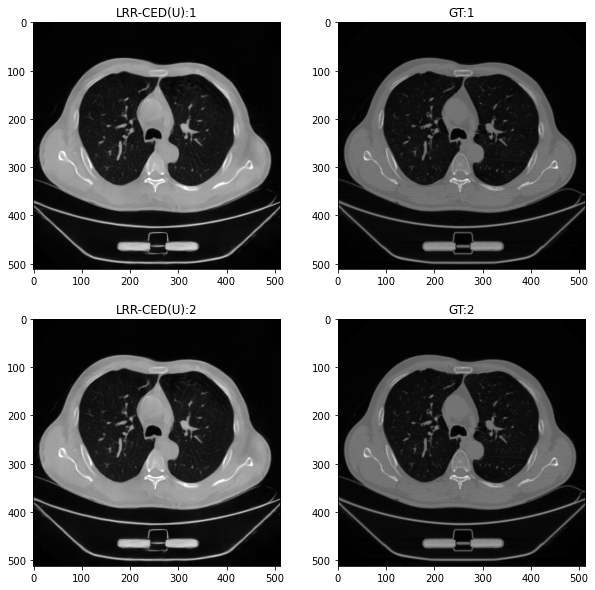

In [13]:
w = 10 # display height
h = 10 # display width

t_n = 2 # number of testing examples to display

GT   = np.zeros((t_n,H,W,1))
pred = np.zeros((t_n,H,W,1))


for i in range(0, t_n):
    
    sino, x1,x2, GT[i] = load_img(i,M2,N2)
    pred[i] = unet_1.predict([sino,x1,x2])

f, axarr = plt.subplots(t_n,2,figsize=(w,h))

for k in range(t_n):
       
    axarr[k,0].imshow(pred[0].reshape(H,W),cmap="gray")
    axarr[k,0].set_title("LRR-CED(U):"+str(k+1)) 
    axarr[k,1].imshow(GT[0].reshape(H,W),cmap="gray")
    axarr[k,1].set_title("GT:"+str(k+1)) 

plt.show()